# 09__tbs_identification
# finding functional TFBSs based on deletion data

in this notebook, i ..

------

figures in this notebook:
- **Fig 4E, top**: barplot of deletion effect sizes and sequence logo plotted proportionally to the loss scores of lncRNA DLEU1 promoter. all of these plots are made by the MIND algorithm and stored in the data/06__mind_results folder
- **Fig 4D**: heatmap showing all of the significant TFBSs predicted by MIND in HepG2

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from os import walk
from scipy.stats import spearmanr

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *
from del_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
del_dir = "../../data/05__deletions"
out_dir = "../../data/06__tfbs_results"

In [4]:
# file w/ tfs and their expression
tf_expr_f = "../../misc/03__rna_seq_expr/tf_tissue_sp.txt"

In [5]:
fimo_f = "../../misc/05__fimo/pool2.fimo.txt"

In [6]:
index_f = "../../data/00__index/dels_oligo_pool.index.txt"

In [7]:
peak_signal_cutoff = 0.5
peak_length_cutoff = 5
del_buffer = 11

## 1. import deletion data and tf expr file

In [8]:
# hepg2
hepg2_files = []
for (dirpath, dirnames, filenames) in walk("%s/HepG2" % del_dir):
    hepg2_files.extend(filenames)
    break

In [9]:
# k562
k562_files = []
for (dirpath, dirnames, filenames) in walk("%s/K562" % del_dir):
    k562_files.extend(filenames)
    break

In [10]:
hepg2_data = {}
k562_data = {}
for files, data, cell in zip([hepg2_files, k562_files], [hepg2_data, k562_data], ["HepG2", "K562"]):
    data_dir = "%s/%s" % (del_dir, cell)
    for f in files:
        df = pd.read_table("%s/%s" % (data_dir, f))
        data[f] = df

In [11]:
# import tf expr data
tf_expr = pd.read_table(tf_expr_f, sep="\t")
tf_expr.head()

,motif_id,motif_name,ensembl_id,HeLa-S3,HepG2,K562,tissue_sp
0,MA0002.2,RUNX1,ENSG00000159216,1.859569,4.693606,9.631455,0.439869
1,MA0003.3,TFAP2A,ENSG00000137203,21.243269,0.000000,1.048992,0.650207
2,MA0007.3,Ar,ENSG00000169083,0.000000,0.000000,0.001697,0.666667
3,MA0009.2,T,ENSG00000164458,0.000000,0.000000,0.000000,NaN
4,MA0014.2,PAX5,ENSG00000196092,0.001618,0.000000,0.000000,0.666667


In [12]:
fimo = pd.read_table(fimo_f, sep="\t")
fimo.columns = ["motif", "unique_id", "start", "stop", "strand", "score", "p-value", "q-value", "seq"]
fimo.head()

,motif,unique_id,start,stop,strand,score,p-value,q-value,seq
0,ZNF263,WILDTYPE_BUT_HAS_SNP_DELETION__Lincrna.noflip....,39,59,-,27.0204,4.070000e-11,0.000024,GGAGGAGGGAGGGGAGGGGAG
1,ZNF263,WILDTYPE_SNP_INDIV__mrna.noflip.NA__p1@IRX5__c...,24,44,+,26.6735,6.730000e-11,0.000024,GGAGGAGGAAGAGGGAGAGGG
2,RREB1,WILDTYPE_BUT_HAS_SNP_DELETION__mrna.flip.sense...,24,43,-,27.0550,3.310000e-10,0.000043,CCCCACCCCACCCCCACCCC
3,RREB1,FLIPPED_DELETION__mrna.flip.antisense__p1@CDKN...,71,90,+,27.0550,3.310000e-10,0.000043,CCCCACCCCACCCCCACCCC
4,ZNF263,WILDTYPE_BUT_HAS_SNP_DELETION__Lincrna.noflip....,38,58,-,25.3878,3.590000e-10,0.000024,GAGGGAGGGAGGGGAGGGGGG


In [13]:
# filter to tfs that are expr in the 2 cell lines
hepg2_tfs = tf_expr[tf_expr["HepG2"] > 1]["motif_name"]
k562_tfs = tf_expr[tf_expr["K562"] > 1]["motif_name"]

In [14]:
index = pd.read_table(index_f, sep="\t")
index_elem = index[["unique_id", "tile_name", "chr", "tile_start", "tile_end", "strand", "tile_number"]].drop_duplicates()
index_elem.head()

,unique_id,tile_name,chr,tile_start,tile_end,strand,tile_number
0,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187624.0,-,2.0
80,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187624.0,-,2.0
106,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187624.0,-,2.0
132,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187624.0,-,2.0
158,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187624.0,-,2.0


## 2. filter dfs to only those that are sig active (wt_class)

In [15]:
hepg2_data_filt = {}
k562_data_filt = {}
for data, data_filt in zip([hepg2_data, k562_data], [hepg2_data_filt, k562_data_filt]):
    for key in data:
        df = data[key]
        if df.wt_class.iloc[0] == "sig active":
            data_filt[key] = df

## 3. find "peaks" in the deletion data

In [73]:
peak_length_cutoff % 4

1

In [76]:
def find_peaks(df, peak_signal_cutoff, peak_length_cutoff):
    peak_status = []
    effect_sizes = list(df["mean.log2FC"])
    count = 0
    in_peak = False
    overall_count = 1
    for x in effect_sizes:
        if x <= -peak_signal_cutoff:
            count += 1
            if count >= peak_length_cutoff:
                if in_peak == False:
                    # replace the last peak_length_cutoff elements with "peak"
                    tmp = peak_status[:(-peak_length_cutoff-1)]
                    diff = len(peak_status) - len(tmp)
                    peak_status = list(tmp)
                    peak_status.extend(["peak"] * (diff+1))
                    in_peak = True
                else:
                    peak_status.append("peak")
            else:
                peak_status.append("no peak")
        else:
            in_peak = False
            count = 0
            peak_status.append("no peak")
        overall_count += 1
    df["peak"] = peak_status
    return df

In [77]:
hepg2_data_peaks = {}
k562_data_peaks = {}

for data_filt, data_peaks, cell in zip([hepg2_data_filt, k562_data_filt], [hepg2_data_peaks, k562_data_peaks],
                                       ["HepG2", "K562"]):
    for key in data_filt:
        name = key.split(".")[0]
        strand = key.split(".")[2]
        gene_name = "%s__%s" % (name, strand)
        df = data_filt[key]
        df = find_peaks(df, peak_signal_cutoff, peak_length_cutoff)
        data_peaks[gene_name] = df
        
        # write file
        cell_dir = "%s/%s/0__peaks" % (out_dir, cell)
        !mkdir -p $cell_dir
        df.to_csv("%s/%s.tfbs_peaks.txt" % (cell_dir, gene_name), sep="\t", index=False)

## 4. intersect FIMO motifs w/ peaks

In [78]:
fimo["fixed_name"] = fimo.apply(fix_fimo_names, name_dict=NAME_DICT, loc_dict=LOC_DICT, axis=1)
fimo.head()

,motif,unique_id,start,stop,strand,score,p-value,q-value,seq,fixed_name
0,ZNF263,WILDTYPE_BUT_HAS_SNP_DELETION__Lincrna.noflip....,39,59,-,27.0204,4.070000e-11,0.000024,GGAGGAGGGAGGGGAGGGGAG,LINC00467__p1__tile1__plus
1,ZNF263,WILDTYPE_SNP_INDIV__mrna.noflip.NA__p1@IRX5__c...,24,44,+,26.6735,6.730000e-11,0.000024,GGAGGAGGAAGAGGGAGAGGG,IRX5__p1__tile1__plus
2,RREB1,WILDTYPE_BUT_HAS_SNP_DELETION__mrna.flip.sense...,24,43,-,27.0550,3.310000e-10,0.000043,CCCCACCCCACCCCCACCCC,CDKN2A__p1__tile1__minus
3,RREB1,FLIPPED_DELETION__mrna.flip.antisense__p1@CDKN...,71,90,+,27.0550,3.310000e-10,0.000043,CCCCACCCCACCCCCACCCC,CDKN2A__p1__tile2__plus
4,ZNF263,WILDTYPE_BUT_HAS_SNP_DELETION__Lincrna.noflip....,38,58,-,25.3878,3.590000e-10,0.000024,GAGGGAGGGAGGGGAGGGGGG,LINC00467__p1__tile1__plus


In [79]:
hepg2_data_peaks["GAS5__p1__tile2__minus"].head()

,delpos,mean.log2FC,sd,se,seq,padj,sig,wt_activ,wt_l2fc,wt_class,tile_chr,tile_start,tile_end,peak
0,11,0.126782,0.075280,0.026616,C,0.335664,not sig,4.739875,5.767435,sig active,chr1,173837092.0,173837206.0,no peak
1,12,-0.003410,0.052490,0.018558,T,1.000000,not sig,4.739875,5.767435,sig active,chr1,173837092.0,173837206.0,no peak
2,13,-0.155297,0.037845,0.013380,G,0.056522,not sig,4.739875,5.767435,sig active,chr1,173837092.0,173837206.0,no peak
3,14,-0.075231,0.052872,0.018693,C,1.000000,not sig,4.739875,5.767435,sig active,chr1,173837092.0,173837206.0,no peak
4,15,-0.075231,0.052872,0.018693,C,1.000000,not sig,4.739875,5.767435,sig active,chr1,173837092.0,173837206.0,no peak


In [80]:
hepg2_motif_peaks = {}
k562_motif_peaks = {}

for data_peaks, data_motifs, cell in zip([hepg2_data_peaks, k562_data_peaks], [hepg2_motif_peaks, k562_motif_peaks],
                                         ["HepG2", "K562"]):
    print("")
    print(cell)
    for key in data_peaks:
        print(key)
        df = data_peaks[key]
        fimo_sub = fimo[fimo["fixed_name"] == key]
        motif_positions = zip(list(fimo_sub["start"]), list(fimo_sub["stop"]), list(fimo_sub["motif"]))
        filtered_motifs = []
        filtered_starts = []
        filtered_ends = []
        for start, end, motif in motif_positions:
            for i in range(start, end):
                try:
                    peak_val = df[df["delpos"] == (i + del_buffer)]["peak"].iloc[0]
                except:
                    continue
                if peak_val == "peak":
                    filtered_motifs.append(motif)
                    filtered_starts.append(start)
                    filtered_ends.append(end)
                    break
        data_motifs[key] = {"motif": filtered_motifs, "start": filtered_starts, "end": filtered_ends}


HepG2
enhancer_NEAT1__pX__tile2__minus
enhancer_MALAT1__pX__tile1__minus
enhancer_MALAT1__pX__tile2__minus
enhancer_TERC__pX__tile2__minus
enhancer_LINC_PINT__pX__tile1__minus
FALEC__p1__tile2__plus
GAS5__p1__tile1__minus
GAS5__p1__tile2__minus
ZBTB37__p1__tile1__plus
ZBTB37__p1__tile2__plus
LINC00467__p1__tile1__plus
LINC00467__p1__tile2__plus
NEAT1__p1__tile2__plus
MALAT1__p4__tile1__plus
MALAT1__p4__tile2__plus
MALAT1__p1__tile1__plus
HOTAIR__p1__tile2__minus
DLEU1__p1__tile1__plus
DLEU1__p1__tile2__plus
MEG3__p1__tile2__plus
CRNDE__p1__tile1__minus
CRNDE__p1__tile2__minus
FENDRR__p1__tile2__minus
FOXF1__p__tile1__plus
FOXF1__p__tile2__plus
ZFAS1__p1__tile1__plus
ZFAS1__p1__tile2__plus
TERC__p1__tile1__minus
TERC__p1__tile2__minus
SAMMSON__p1__tile2__plus
LUCAT1__p1__tile2__minus
LINC_PINT__p2__tile1__minus
PVT1__p1__tile1__plus
PVT1__p1__tile2__plus
CDKN2A__p1__tile1__minus
CDKN2A__p1__tile2__minus
ANRIL__p1__tile2__plus
JPX__p1__tile1__plus
JPX__p1__tile2__plus
CRNDE__p1__tile1__

In [81]:
hepg2_motif_dfs = {}
k562_motif_dfs = {}

for data_motifs, dfs in zip([hepg2_motif_peaks, k562_motif_peaks], [hepg2_motif_dfs, k562_motif_dfs]):
    for key in data_motifs:
        data = data_motifs[key]
        df = pd.DataFrame.from_dict(data)
        df = df[["motif", "start", "end"]]
        df = df.drop_duplicates()
        dfs[key] = df
        
        # write file
        cell_dir = "%s/%s/1__motifs" % (out_dir, cell)
        !mkdir -p $cell_dir
        df = df.sort_values(by="start", ascending=True)
        df.to_csv("%s/%s.tfbs_peaks.txt" % (cell_dir, gene_name), sep="\t", index=False)

hepg2_motif_dfs["GAS5__p1__tile2__minus"].head()

,motif,start,end
0,BATF3,26,39
26,ATF7,26,39
62,NEUROG2,70,79
63,NRF1,18,28
64,Neurog1,70,79


## 5. limit to TFs expressed in each cell line

In [82]:
hepg2_motif_dfs_filt = {}
k562_motif_dfs_filt = {}

for motif_dfs, motif_dfs_filt, tfs in zip([hepg2_motif_dfs, k562_motif_dfs], 
                                          [hepg2_motif_dfs_filt, k562_motif_dfs_filt],
                                          [hepg2_tfs, k562_tfs]):
    for key in motif_dfs:
        df = motif_dfs[key]
        sub = df[df["motif"].isin(tfs)]
        motif_dfs_filt[key] = sub

hepg2_motif_dfs_filt["GAS5__p1__tile2__minus"].head()

,motif,start,end
26,ATF7,26,39
63,NRF1,18,28
70,CREB3,26,39
78,JUND(var.2),24,38
97,JUND(var.2),25,39


## 6. make heatmap with TFs mapped in each sequence
note: use only HepG2 since there are more seqs expressed in HepG2 and use results filtered by TFs expr in HepG2

In [83]:
# first, put all gene data in dictionary of list of dataframes
hepg2_gene_data = {}
k562_gene_data = {}

for tile_data, gene_data in zip([hepg2_motif_dfs_filt, k562_motif_dfs_filt], [hepg2_gene_data, k562_gene_data]):
    for key in tile_data:
        data = tile_data[key]

        if "enhancer" not in key:
            gene_name = key.split("_")[0]
            prom_name = key.split("_")[1]
            tile_name = key.split("_")[2]
            strand_name = key.split("_")[3]
        else:
            gene_name = key.split("_")[0] + "_" + key.split("_")[1]
            prom_name = key.split("_")[2]
            tile_name = key.split("_")[3]
            strand_name = key.split("_")[4]

        data["gene_name"] = gene_name
        data["prom_name"] = prom_name
        data["tile_name"] = tile_name
        data["strand_name"] = strand_name

        if "LINC" in gene_name:
            if "00467" not in gene_name:
                if "enhancer" in gene_name:
                    gene_name = "enhancer_LINC-PINT"
                else:
                    gene_name = "LINC-PINT"
        if gene_name not in gene_data:
            gene_data[gene_name] = [data]
        else:
            current_gene_data = gene_data[gene_name]
            current_gene_data.append(data)

list(hepg2_gene_data.keys())[0:5]

['enhancer_NEAT1',
 'enhancer_MALAT1',
 'enhancer_TERC',
 'enhancer_LINC-PINT',
 'FALEC']

In [84]:
hepg2_sig_data = {}
k562_sig_data = {}

hepg2_all_motifs = []
k562_all_motifs = []

for sig_data, all_motifs, gene_data in zip([hepg2_sig_data, k562_sig_data], [hepg2_all_motifs, k562_all_motifs],
                                           [hepg2_gene_data, k562_gene_data]):
    for gene in gene_data:
        dfs = gene_data[gene]
        gene_motifs = []
        for df in dfs:
            gene_motifs.extend(list(df["motif"]))
        gene_motifs = list(set(gene_motifs))
        all_motifs.extend(gene_motifs)
        if len(gene_motifs) == 0:
            continue
        sig_data[gene] = gene_motifs

In [85]:
hepg2_all_motifs = list(set(hepg2_all_motifs))
len(hepg2_all_motifs)

104

In [86]:
hepg2_motif_idx_dict = {k:v for k, v in zip(hepg2_all_motifs, list(range(0, len(hepg2_all_motifs))))}

In [87]:
hepg2_motif_array = np.zeros((len(hepg2_sig_data), len(hepg2_all_motifs)))
for i, gene in enumerate(hepg2_sig_data):
    motif_data = hepg2_sig_data[gene]
    motif_idxs = [hepg2_motif_idx_dict[motif] for motif in motif_data]
    #print(gene)
    for j in motif_idxs:
        hepg2_motif_array[i, j] = 1

hepg2_mo_df = pd.DataFrame(hepg2_motif_array, index=list(hepg2_sig_data.keys()), columns=hepg2_all_motifs)
hepg2_mo_df.head()

,MAFK,RARA(var.2),SP4,E2F8,JDP2(var.2),Zfx,NFIA,GRHL1,STAT1,ELK4,...,TBX2,HNF4G,KLF16,CTCF,CENPB,ETV4,ZBTB7B,NRF1,NFKB2,TBP
enhancer_NEAT1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
enhancer_MALAT1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
enhancer_LINC-PINT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FALEC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
GAS5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [88]:
cmap = sns.light_palette("firebrick", reverse=False, as_cmap=True)

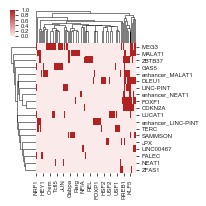

In [89]:
cg = sns.clustermap(hepg2_mo_df, annot=False, cmap=cmap, figsize=(2.25, 3))
cg.savefig("Fig_4D.pdf", bbox_inches="tight", dpi="figure")

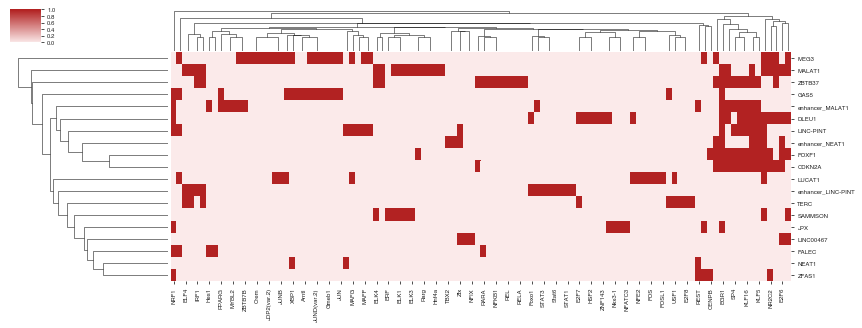

In [90]:
cg = sns.clustermap(hepg2_mo_df, annot=False, cmap=cmap, figsize=(14, 5))
cg.savefig("Fig_4D_big.pdf", bbox_inches="tight", dpi="figure")

## 7. plot number of motifs found in seqs expressed in only one cell type vs. two

In [91]:
expr_in_hepg2_not_k562 = [x for x in hepg2_gene_data.keys() if x not in k562_gene_data.keys()]
expr_in_both = [x for x in hepg2_gene_data.keys() if x in k562_gene_data.keys()]
expr_in_hepg2_not_k562

['enhancer_NEAT1',
 'enhancer_TERC',
 'enhancer_LINC-PINT',
 'NEAT1',
 'HOTAIR',
 'CRNDE',
 'FENDRR',
 'PVT1',
 'CDKN2A']

In [92]:
hepg2_sig_data.keys()

dict_keys(['enhancer_NEAT1', 'enhancer_MALAT1', 'enhancer_LINC-PINT', 'FALEC', 'GAS5', 'ZBTB37', 'LINC00467', 'NEAT1', 'MALAT1', 'DLEU1', 'MEG3', 'FOXF1', 'ZFAS1', 'TERC', 'SAMMSON', 'LUCAT1', 'LINC-PINT', 'CDKN2A', 'JPX'])

In [93]:
results_dict = {}
for gene in expr_in_hepg2_not_k562:
    try:
        sig_motifs = hepg2_sig_data[gene]
        n_sig_motifs = len(sig_motifs)
    except:
        n_sig_motifs = 0
    results_dict[gene] = (n_sig_motifs, "on in hepg2, not k562")
    
for gene in expr_in_both:
    try:
        hepg2_sig_motifs = hepg2_sig_data[gene]
    except:
        hepg2_sig_motifs = []
    try:
        k562_sig_motifs = k562_sig_data[gene]
    except:
        k562_sig_motifs = []
    hepg2_sig_motifs.extend(k562_sig_motifs)
    all_motifs = list(set(hepg2_sig_motifs))
    n_sig_motifs = len(all_motifs)
    results_dict[gene] = (n_sig_motifs, "on in both")

results_df = pd.DataFrame.from_dict(results_dict, orient="index").reset_index()
results_df.columns = ["gene", "n_sig_motifs", "type"]
results_df.head()

,gene,n_sig_motifs,type
0,enhancer_NEAT1,9,"on in hepg2, not k562"
1,enhancer_TERC,0,"on in hepg2, not k562"
2,enhancer_LINC-PINT,12,"on in hepg2, not k562"
3,NEAT1,3,"on in hepg2, not k562"
4,HOTAIR,0,"on in hepg2, not k562"


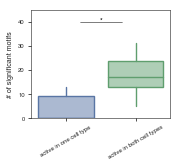

In [94]:
fig = plt.figure(figsize=(2.5, 2))
ax = sns.boxplot(data=results_df, x="type", y="n_sig_motifs", flierprops = dict(marker='o', markersize=5))
ax.set_xticklabels(["active in one cell type", "active in both cell types"], rotation=30)
mimic_r_boxplot(ax)
plt.xlabel("")
plt.ylabel("# of significant motifs")
plt.ylim((-0.1, 45))


# calc p-vals b/w dists
one_dist = np.asarray(results_df[results_df["type"] == "on in hepg2, not k562"]["n_sig_motifs"])
both_dist = np.asarray(results_df[results_df["type"] == "on in both"]["n_sig_motifs"])

one_dist = one_dist[~np.isnan(one_dist)]
both_dist = both_dist[~np.isnan(both_dist)]

u, pval = stats.mannwhitneyu(one_dist, both_dist, alternative="less", use_continuity=False)

# statistical annotation
annotate_pval(ax, 0.2, 0.8, 40, 0, 39, pval, fontsize)

fig.savefig("Fig_S15B.pdf", dpi="figure", bbox_inches="tight")

## 8. plot correlation b/w number of motifs found and ref tile activity

In [95]:
hepg2_dict = {}
k562_dict = {}

for del_dict, motif_dict, d in zip([hepg2_data_peaks, k562_data_peaks], 
                                   [hepg2_motif_dfs, k562_motif_dfs], 
                                   [hepg2_dict, k562_dict]):
    for key in del_dict:
        df = del_dict[key]
        wt_activ = df["wt_activ"].iloc[0]
        
        # find num sig motifs
        motifs = motif_dict[key]
        n_tot_sig = len(list(set(list(motifs["motif"]))))
            
        d[key] = [wt_activ, n_tot_sig]

In [96]:
hepg2_activ = pd.DataFrame.from_dict(hepg2_dict, orient="index").reset_index()
hepg2_activ.columns = ["seq_name", "activ", "n_sig"]

k562_activ = pd.DataFrame.from_dict(k562_dict, orient="index").reset_index()
k562_activ.columns = ["seq_name", "activ", "n_sig"]

In [97]:
hepg2_activ.head()

,seq_name,activ,n_sig
0,enhancer_NEAT1__pX__tile2__minus,0.024331,23
1,enhancer_MALAT1__pX__tile1__minus,-0.116371,0
2,enhancer_MALAT1__pX__tile2__minus,3.202182,36
3,enhancer_TERC__pX__tile2__minus,-0.504331,0
4,enhancer_LINC_PINT__pX__tile1__minus,0.060140,18


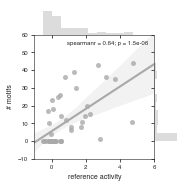

In [98]:
g = sns.jointplot(data=hepg2_activ, x="activ", y="n_sig", kind="reg", space=0, size=2.625, stat_func=spearmanr, 
                  marginal_kws={"hist": True, "kde": False, "bins": 10}, color="darkgrey", scatter_kws={"s": 25},
                  xlim=(-1, 6), ylim=(-10, 60))
g.set_axis_labels("reference activity", "# motifs")
g.savefig("Fig_S15A_1.pdf", dpi="figure", bbox_inches="tight")

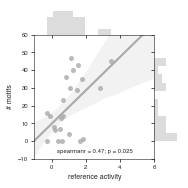

In [99]:
g = sns.jointplot(data=k562_activ, x="activ", y="n_sig", kind="reg", space=0, size=2.625, stat_func=spearmanr, 
                  marginal_kws={"hist": True, "kde": False, "bins": 10}, color="darkgrey", scatter_kws={"s": 25},
                  xlim=(-1, 6), ylim=(-10, 60))
g.set_axis_labels("reference activity", "# motifs")
g.savefig("Fig_S15A_2.pdf", dpi="figure", bbox_inches="tight")